In [115]:
import pandas as pd
import numpy as np
import json
import datetime 

In [116]:
sourceCheckins = pd.read_csv('data/July/server/checkins.tsv', sep='\t')
allCheckins = pd.read_csv('data/July/server/currentExtendedCheckinsHistory.tsv', sep='\t')
checkpoints = pd.read_csv('data/July/server/checkPoints.tsv', sep='\t')

In [120]:
len(np.unique(allCheckins.userId.tolist()))

2568

In [121]:
len(allCheckins)

283487

In [119]:
allCheckins = allCheckins.drop_duplicates(subset = ['checkinId'])

In [9]:
allCheckins = pd.concat([checkins1, checkins])

In [3]:
allCheckins = pd.read_csv('data/July/server/currentExtendedCheckinsHistory.tsv', sep='\t')

In [399]:
allCheckins.to_csv('data/July/server/currentExtendedCheckinsHistory.tsv', sep='\t', encoding='utf-8')

In [ ]:
allCheckins.drop('Unnamed: 0.1', axis=1, inplace=True)

In [124]:
sortedVenues = []
sortedVenuesIds = []
for venueId, group in allCheckins.groupby('venueId').agg('size').order(ascending = False).iteritems():
    sortedVenues.append({'venueId':venueId,
                        'group':group})
    sortedVenuesIds.append(venueId)

In [115]:
#'World Class Lite in top ten!, 520f117111d2a782f1211c3b'

In [125]:
groupedUsers = allCheckins.groupby('userId')
userVenues = []
for index, group in enumerate(groupedUsers):
        userVenues.append(group[1]['venueId'].tolist())

In [126]:
len(sortedVenues)

66667

In [127]:
top50VenuesCheckins = allCheckins[allCheckins.venueId.isin(sortedVenuesIds[:50])]

In [128]:
for venueId in sortedVenuesIds[:50]:
    print venueNameFromId(venueId)

ЦПКиО им. Горького / Gorky Park
Москва / Moscow
Парк искусств «Музеон» / Muzeon Park
ВДНХ (Выставка достижений народного хозяйства)
Международный аэропорт Домодедово / Domodedovo International Airport (DME)
Россия / Russia
Красная площадь / Red Square
ПКиО «Сокольники»
Международный аэропорт Шереметьево / Sheremetyevo International Airport (SVO)
ТРЦ «Европейский»
Арбат / Arbat Street
Афимолл Сити / Afimall City
ТРК «Атриум» / Atrium Mall
Международный аэропорт Внуково / Vnukovo International Airport (VKO)
Центральный детский магазин
ТЦ «Метрополис»
Ленинградский вокзал / Leningradsky Railway Terminal
ТЦ «Охотный ряд»
Патриаршие пруды / Patriarshiye Ponds
Музей-заповедник «Коломенское»
Московский вокзал / Moskovsky Railway Station
Парк Победы (Поклонная гора) / Victory Park
Нескучный сад
ГУМ / GUM
ТРЦ «Авиапарк»
Tsvetnoy Central Market
Физика
Курский вокзал / Kursky Rail Terminal
Казанский вокзал / Kazansky Rail Terminal
Музей-заповедник «Царицыно»
ТРЦ «Золотой Вавилон»
Воробьёвская наб

In [ ]:
from pymining import itemmining
relim_input = itemmining.get_relim_input(userVenues)
report = itemmining.relim(relim_input, min_support=2)
report

In [313]:
def load_dataset():
    "Load the sample dataset."
    return userVenues
 
 
def createC1(dataset):
    "Create a list of candidate item sets of size one."
    c1 = []
    for transaction in dataset:
        for item in transaction:
            if not [item] in c1:
                c1.append([item])
    c1.sort()
    #frozenset because it will be a ket of a dictionary.
    return map(frozenset, c1)
 
 
def scanD(dataset, candidates, min_support):
    "Returns all candidates that meets a minimum support level"
    sscnt = {}
    for tid in dataset:
        for can in candidates:
            if can.issubset(tid):
                sscnt.setdefault(can, 0)
                sscnt[can] += 1
 
    num_items = float(len(dataset))
    retlist = []
    support_data = {}
    for key in sscnt:
        support = sscnt[key] / num_items
        if support >= min_support:
            retlist.insert(0, key)
        support_data[key] = support
    return retlist, support_data
 
 
def aprioriGen(freq_sets, k):
    "Generate the joint transactions from candidate sets"
    retList = []
    lenLk = len(freq_sets)
    for i in range(lenLk):
        for j in range(i + 1, lenLk):
            L1 = list(freq_sets[i])[:k - 2]
            L2 = list(freq_sets[j])[:k - 2]
            L1.sort()
            L2.sort()
            if L1 == L2:
                retList.append(freq_sets[i] | freq_sets[j])
    return retList
 
 
def apriori(dataset, minsupport=0.5):
    "Generate a list of candidate item sets"
    C1 = createC1(dataset)
    D = map(set, dataset)
    L1, support_data = scanD(D, C1, minsupport)
    L = [L1]
    k = 2
    while (len(L[k - 2]) > 0):
        Ck = aprioriGen(L[k - 2], k)
        Lk, supK = scanD(D, Ck, minsupport)
        support_data.update(supK)
        L.append(Lk)
        k += 1
 
    return L, support_data

In [ ]:
C1 = createC1(userVenues)

In [252]:
D = map(set, userVenues)

In [253]:
L1, support_data = scanD(D, C1, 0.01)

In [315]:
L, supportData = apriori(userVenues, minsupport=0.01)

In [316]:
frequentVenues = []
for itemset, support in zip(L, supportData):
    if len(itemset)>5:
        print support
        frequentVenueSet = []
        for item in itemset:
            frequentVenueSet.append(next(enumerate(item))[1])
        frequentVenues.append(frequentVenueSet)

frozenset(['4be6909fd4f7c9b6b2e02620', '4ba6146ef964a5202d3239e3'])
frozenset(['4bd855b5f645c9b6f5a1a7e0', '4bae5064f964a52077a13be3'])
frozenset(['4bdd5f27f219c9b6bb751210', '5526587c498e151e3d6ab2f4', '523c543311d2343c967a796e'])
frozenset(['534f9f0b498ea76789184be0', '515dcc1ae4b0b437d6ad9c66'])
frozenset(['534a9d1e498e5b2d5c3e5125'])
frozenset(['4c0b65a2bbc676b003864bd5', '4ba91963f964a520480b3ae3'])


In [40]:
len(userVenues)*0.0015455950541

1.0000000000027

In [319]:
for venueId in frequentVenues[0][:20]:
    print venueNameFromId(venueId)

Афимолл Сити / Afimall City
Гин-но Таки
McDonald's
Cuba Libre
Hard Rock Cafe Moscow
Conversation Cafe
Bar BQ Cafe
Страна которой нет
Каро Vegas 22
Площадь Киевского Вокзала
Счастье
Площадь Восстания
Starbucks
Аэроэкспресс - Терминал на Павелецком вокзале
Osteria della Piazza Bianca
ТРK «Вегас» (Крокус Сити)
Декатлон
ТК «Горбушка»
Теплый Стан
Площадь Революции


In [318]:
def generateRules(L, support_data, min_confidence=0.7):
    """Create the association rules
    L: list of frequent item sets
    support_data: support data for those itemsets
    min_confidence: minimum confidence threshold
    """
    rules = []
    for i in range(1, len(L)):
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]
            #print "freqSet", freqSet, 'H1', H1
            if (i > 1):
                rules_from_conseq(freqSet, H1, support_data, rules, min_confidence)
            else:
                calc_confidence(freqSet, H1, support_data, rules, min_confidence)
    return rules
 
 
def calc_confidence(freqSet, H, support_data, rules, min_confidence=0.7):
    "Evaluate the rule generated"
    pruned_H = []
    for conseq in H:
        conf = support_data[freqSet] / support_data[freqSet - conseq]
        if conf >= min_confidence:
            print freqSet - conseq, '--->', conseq, 'conf:', conf
            rules.append((freqSet - conseq, conseq, conf))
            pruned_H.append(conseq)
    return pruned_H
 
 
def rules_from_conseq(freqSet, H, support_data, rules, min_confidence=0.7):
    "Generate a set of candidate rules"
    m = len(H[0])
    if (len(freqSet) > (m + 1)):
        Hmp1 = aprioriGen(H, m + 1)
        Hmp1 = calc_confidence(freqSet, Hmp1,  support_data, rules, min_confidence)
        if len(Hmp1) > 1:
            rules_from_conseq(freqSet, Hmp1, support_data, rules, min_confidence)

In [ ]:
rules = generateRules(L, supportData, min_confidence=0.6)

# Helper Functions

In [129]:
venuesDict = {}
def venueNameFromId(venueId):
    if venueId not in venuesDict.keys():
        venuesDict[venueId] = allCheckins[allCheckins.venueId == venueId].iloc[0]['name']
    return venuesDict[venueId]

In [130]:
venuesCatDict = {}
def venueCategoryFromId(venueId):
    if venueId not in venuesDict.keys():
        venuesDict[venueId] = allCheckins[allCheckins.venueId == venueId].iloc[0]['categoryName']
    return venuesDict[venueId]

In [131]:
categoriesDict = {}
def categoryNameFromId(categoryId):
    if categoryId not in categoriesDict.keys():
        categoriesDict[categoryId] = allCheckins[allCheckins.categoryId == categoryId].iloc[0]['categoryName']
    return categoriesDict[categoryId]

In [132]:
def countUsersAtVenue(venuedId):
    return len(np.unique(allCheckins[allCheckins.venueId == venueId]['userId'].tolist()))

In [321]:
for rule in rules:
    simpleRule = 1
    if len(rule[0]) < 2:
        continue
        
    for venueId in enumerate(rule[0]):
        if venueId[1] not in sortedVenuesIds[:20]:
            simpleRule = 0
            
    if simpleRule:
        continue
    
    simpleRule = 1
    
    for venueId in enumerate(rule[1]):
        if venueId[1] not in sortedVenuesIds[:20]:
            simpleRule = 0
            
    if simpleRule:
        continue
    
    for venueId in enumerate(rule[0]):
        print venueNameFromId(venueId[1])
        
    print '--->'
    for venueId in enumerate(rule[1]):
        print venueNameFromId(venueId[1])
    print 'conf:', rule[2]
    print ''

ТРЦ «Галерея» / Galeria Shopping Mall
ВДНХ (Выставка достижений народного хозяйства)
--->
Ленинградский вокзал / Leningradsky Railway Terminal
Московский вокзал / Moskovsky Railway Station
conf: 0.615384615385

Невский проспект / Nevsky Prospect
Московский вокзал / Moskovsky Railway Station
--->
Ленинградский вокзал / Leningradsky Railway Terminal
Дворцовая площадь / Palace Square
conf: 0.607142857143

Парк искусств «Музеон» / Muzeon Park
Каро 17 SKY
--->
ЦПКиО им. Горького / Gorky Park
ТРЦ «Авиапарк»
conf: 0.64

Государственный Эрмитаж / Hermitage Museum
Ленинградский вокзал / Leningradsky Railway Terminal
--->
ЦПКиО им. Горького / Gorky Park
Московский вокзал / Moskovsky Railway Station
conf: 0.64

ВДНХ (Выставка достижений народного хозяйства)
Дворцовая площадь / Palace Square
--->
Ленинградский вокзал / Leningradsky Railway Terminal
Московский вокзал / Moskovsky Railway Station
conf: 0.606060606061

Ленинградский вокзал / Leningradsky Railway Terminal
Невский проспект / Nevsky Pros

In [ ]:
#Using code for rules from here: http://aimotion.blogspot.ru/2013/01/machine-learning-and-data-mining.html

In [268]:
multiUserSortedVenues = filter(lambda x: x['group'] > 1, sortedVenues)

In [168]:
userVenueGroups = []
for venueId, group in allCheckins.groupby('venueId'):
    if len(group.groupby('userId'))>10:
        userVenueGroups.append(venueId)

In [134]:
userVenueCategories = []
for categoryId, group in allCheckins.groupby('categoryId'):
    if len(group.groupby('userId'))>1:
        userVenueCategories.append(categoryId)

In [169]:
#Make lists of users check-in venues
multiUserCheckins = allCheckins[allCheckins.venueId.isin(userVenueGroups)]
groupedUsers = multiUserCheckins.groupby('userId')
userVenuesList = []
userIds = []
for index, group in enumerate(groupedUsers):
        userVenuesList.append(group[1]['venueId'].tolist())
        userIds.append(group[0])

In [136]:
#Make lists of users check-in catrgories
fineCheckins = allCheckins[allCheckins.categoryId.isin(userVenueCategories)]
groupedUsers = fineCheckins.groupby('userId')
userCategoryList = []
userIdsForCat = []
for index, group in enumerate(groupedUsers):
        userCategoryList.append(group[1]['categoryId'].tolist())
        userIdsForCat.append(group[0])

In [160]:
len(userVenueGroups)

1858

# K-means, spectral

In [141]:
#Let's build some TF-ID vectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import MiniBatchKMeans

In [170]:
venuesByUser = []
for userList in userVenuesList:
    venuesByUser.append(' '.join(userList))
    
categoriesByUser = []
for userList in userCategoryList:
    try:
        categoriesByUser.append(' '.join(userList))
    except:
        print userList

tfidf_vectorizer = TfidfVectorizer(vocabulary = userVenueGroups)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(venuesByUser)

In [143]:
from time import time
cocluster = SpectralCoclustering(n_clusters=20,
                                 svd_method='arpack', random_state=0)
kmeans = MiniBatchKMeans(n_clusters=20,
                         random_state=0)

print("Coclustering...")
start_time = time()
cocluster.fit(tfidf_matrix_train)
y_cocluster = cocluster.row_labels_
print("Done in {:.2f}s.".format(
    time() - start_time))

print("MiniBatchKMeans...")
start_time = time()
y_kmeans = kmeans.fit_predict(tfidf_matrix_train)
print("Done in {:.2f}s.".format(
    time() - start_time))

feature_names = tfidf_vectorizer.get_feature_names()

Coclustering...
Done in 0.36s.
MiniBatchKMeans...
Done in 0.09s.


In [41]:
clustersSpectral = [[] for i in range(20)]
for index, clusterId in enumerate(y_cocluster):
    clustersSpectral[clusterId].append(userIds[index])

In [42]:
np.std([len(cluster) for cluster in  clusters])

NameError: name 'clusters' is not defined

In [43]:
clusters = x = [[] for i in range(20)]
for index, clustedId in enumerate(y_kmeans):
    clusters[clustedId].append(userIds[index])

# LDA

In [171]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer 

cv = sklearn.feature_extraction.text.CountVectorizer()
mat = cv.fit_transform(venuesByUser).toarray()
print('Done Document matrix')

Done Document matrix


In [172]:
sum([len(venuesUser) for venuesUser in userVenuesList])

95054

In [146]:
cvCategory = sklearn.feature_extraction.text.CountVectorizer()
matCategory = cvCategory.fit_transform(categoriesByUser).toarray()
print('Done Document matrix')

Done Document matrix


In [147]:
len(userVenueCategories)

559

In [173]:
venuesVocab = cv.get_feature_names()
print len(venuesVocab)

1859


In [149]:
categoriesVocab = cvCategory.get_feature_names()
print len(categoriesVocab)

559


In [174]:
import lda
model20 = lda.LDA(n_topics=20, n_iter=2000, random_state=1,alpha = 0.001)
model20.fit(mat)  # model.fit_transform(X) is also available
topic_word = model20.topic_word_  # model.components_ also works
print('Done LDA fitting')

Done LDA fitting


In [65]:
import lda
model20Cat = lda.LDA(n_topics=20, n_iter=2000, random_state=1,alpha = 0.001)
model20Cat.fit(matCategory)  # model.fit_transform(X) is also available
topic_cats = model20Cat.topic_word_  # model.components_ also works
print('Done LDA fitting')

Done LDA fitting


In [175]:
n_top_venues = 10
for i, venues_dist in enumerate(topic_word):
    indicies = np.argsort(venues_dist)[::-1]
    topic_venues = np.array(venuesVocab)[indicies]
    topic_probs = venues_dist[indicies]
    #print np.sort(venues_dist)[:-n_top_venues:-1]
    print('Cluster {}:'.format(i+1))
    for venueId, topicProb in zip(topic_venues, topic_probs):
        if topicProb>=0.01:
            print("{}, {} users {:.2f}%").format(venueNameFromId(venueId),countUsersAtVenue(venueId),topicProb*100)
        else:
            break
    print ''

Cluster 1:
Международный аэропорт Шереметьево / Sheremetyevo International Airport (SVO), 408 users 10.41%
Международный аэропорт Домодедово / Domodedovo International Airport (DME), 591 users 7.67%
Международный аэропорт Внуково / Vnukovo International Airport (VKO), 382 users 4.87%
Терминал D / Terminal D, 149 users 3.24%
Башня «Федерация» / Federation Tower, 39 users 1.59%
ЦПКиО им. Горького / Gorky Park, 1316 users 1.17%
Аэроэкспресс - Терминал на Белорусском вокзале / Aeroexpress Terminal at Belorusski Railway Station, 69 users 1.11%
Международный аэропорт Симферополь / Simferopol International Airport (SIP), 40 users 1.02%

Cluster 2:
ЦПКиО им. Горького / Gorky Park, 1316 users 7.23%
ТРЦ «Европейский», 419 users 2.92%
Парк искусств «Музеон» / Muzeon Park, 755 users 2.46%
ТРЦ «Columbus», 99 users 2.13%
ТРК «Капитолий», 118 users 1.79%
Арбат / Arbat Street, 430 users 1.52%
ТРЦ «Филион», 85 users 1.49%
Красная площадь / Red Square, 586 users 1.36%
Афимолл Сити / Afimall City, 345 us

# Create LDA users clusters

In [152]:
def exportLDAClustersToCSV(venues_clusters, allCheckins):
    topVenuesLDA = []
    LDAclustersDF = pd.DataFrame()
    for clustedId, venues_dist in enumerate(venues_clusters):
        indicies = np.argsort(venues_dist)[::-1]
        
        topic_venues = np.array(venuesVocab)[indicies]
        topic_probs = venues_dist[indicies]

        topVenuesIds =  [venueId for venueId, topicProb in zip(topic_venues, topic_probs) if topicProb>=0.01]
        topVenuesLDA.extend(topVenuesIds)
        clusterCheckins = allCheckins[allCheckins.venueId.isin(topVenuesIds)]
        clusterCheckins["clusterId"] = clustedId+1
        LDAclustersDF = LDAclustersDF.append(clusterCheckins)
    print len(topVenuesLDA)
    print len(set(topVenuesLDA))
    return LDAclustersDF

In [153]:
LDAclustersDF = exportLDAClustersToCSV(topic_word, allCheckins)

318
221


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [154]:
LDAclustersDF.to_csv('data/July/LDATopVenuesMoreThan10.tsv', sep="\t", encoding="utf-8")

In [ ]:
LDAclusteredUsersDF = pd.DataFrame()
for clusterId, clusterLDA in enumerate(clustersLDA):
    clusterCheckins = allCheckins[allCheckins.userId.isin(clusterLDA)]
    clusterCheckins["clusterId"] = clusterId + 1
    LDAclusteredUsersDF = LDAclusteredUsersDF.append(clusterCheckins)
    print len(clusterLDA)

In [177]:
LDAclusteredUsersDF.to_csv('data/July/LDAClusteredUsersMoreThan10.tsv', sep="\t", encoding="utf-8")

In [176]:
from datetime import datetime
def extractComponents(row):
    date = datetime.utcfromtimestamp(row.createdAt+180*60)
    hours.append(date.hour)
    weekdays.append(date.weekday())
    
hours = []
weekdays = []

LDAclusteredUsersDF.apply(extractComponents, axis=1)
LDAclusteredUsersDF['hour'] = hours
LDAclusteredUsersDF['weekday'] = weekdays

In [81]:
LDAclusteredUsersDF.keys()

Index([u'categoryId', u'categoryName', u'checkinId', u'checkinsCount',
       u'createdAt', u'createdAtDate', u'lat', u'lng', u'name', u'tipCount',
       u'userId', u'usersCount', u'venueId', u'clusterId'],
      dtype='object')

In [79]:
for index, group in enumerate(LDAclusteredUsersDF.groupby("clusterId")):
        print len(group[1])

6275
8053
9921
10156
30774
9145
7544
20819
8100
11291
12421
11874
9103
6278
9698
10092
9087
7612
8984
7868


In [ ]:
for clusterLDA,clusterLDACat  in zip(clustersLDA,clustersLDACategory):
    print len(clusterLDA), len(clusterLDACat)

In [109]:
LDACheckins = allCheckins[allCheckins.venueId.isin(venuesVocab)]
print len(LDACheckins)

134866


In [ ]:
LDAclusteredCategoriesDF = pd.DataFrame()
for clusterId, clusterLDA in enumerate(clustersLDACategory):
    clusterCheckins = LDACheckins[LDACheckins.userId.isin(clusterLDA)]
    clusterCheckins["clusterId"] = clusterId + 1
    LDAclusteredCategoriesDF = LDAclusteredCategoriesDF.append(clusterCheckins)
    print len(clusterCheckins)
LDAclusteredCategoriesDF.to_csv('data/July/LDAClusteredUsersByCategory.tsv', sep="\t", encoding="utf-8")

In [155]:
clustersLDA = [[] for i in range(20)]
for index, userTopics in enumerate(model20.ndz_):
    clustersLDA[np.argmax(userTopics)].append(userIds[index])

In [102]:
clustersLDACategory = [[] for i in range(20)]
for index, userTopics in enumerate(model20Cat.ndz_):
    clustersLDACategory[np.argmax(userTopics)].append(userIdsForCat[index])

In [113]:
#Match the clusters by min Jaccard Distance
import distance
LDAClustersMap = []
LDAClustersMapIndexes = []
# clustersLDACopy = clustersLDA
distancesMatrix = []
for clusterK in clusters:
    distances = [distance.jaccard(clusterLDA,clusterK) for clusterLDA in clustersLDA]
    distancesMatrix.append(distances)
    index = np.argmin(distances)
    LDAClustersMap.append(clustersLDA[index])
#     clustersLDACopy.remove(clustersLDA[index])

In [156]:
clustersSpectral1 = [[0] if len(cluster) == 0 else cluster for cluster in clusterSpectreal]

In [ ]:
distancesMatrixKSpect = []
for clusterK in clusters:
    distances = [distance.jaccard(clusterSpectreal,clusterK) for clusterSpectreal in clustersSpectral]
    distancesMatrixKSpect.append(distances)

In [114]:
#Average Jaccard Distance between clusters
print np.mean([distance.jaccard(clusterK, LDAClustersMap[index]) for index, clusterK in enumerate(clusters) if len(clusterK)])

0.891365675713


In [124]:
#Average Jaccard Distance between clusters
print np.mean(np.min(distancesMatrix, axis=1))

0.923955972999


In [89]:
n_top_venues = 10
for i, venues_dist in enumerate(topic_cats):
    indicies = np.argsort(venues_dist)[:-n_top_venues:-1]
    topic_venues = np.array(categoriesVocab)[indicies]
    topic_probs = venues_dist[indicies]
    print('Cluster {}:'.format(i+1))
    for categoryId, topicProb in zip(topic_venues, topic_probs):
        if topicProb>=0.01:
            print("{}, {:.2f}%").format(categoryNameFromId(categoryId),topicProb*100)
        else:
            break
    print ''

Cluster 1:
Residential Building (Apartment / Condo), 10.83%
Mall, 10.52%
Coffee Shop, 9.17%
Bank, 6.00%
Park, 5.05%
Fast Food Restaurant, 4.54%
Grocery Store, 2.16%
Big Box Store, 2.15%
Sushi Restaurant, 1.95%

Cluster 2:
Park, 5.66%
Coffee Shop, 5.09%
Airport, 4.82%
Mall, 4.81%
Hotel, 3.55%
Café, 3.08%
Train Station, 2.73%
City, 2.12%
Restaurant, 1.76%

Cluster 3:
Office, 19.11%
Gym / Fitness Center, 17.62%
Tech Startup, 6.05%
Airport, 3.92%
Cocktail Bar, 2.27%
Park, 1.97%
Medical Center, 1.97%
Mall, 1.88%
Hotel, 1.83%

Cluster 4:
Home (private), 43.82%
Office, 4.58%
Mall, 4.33%
Residential Building (Apartment / Condo), 3.73%
Gym Pool, 2.25%
Capitol Building, 1.96%
Financial or Legal Service, 1.37%
Airport, 1.33%
Clothing Store, 1.29%

Cluster 5:
Gym / Fitness Center, 66.53%
Mall, 6.70%
College Communications Building, 1.96%
Train Station, 1.67%
Park, 1.56%
Salon / Barbershop, 1.56%
Multiplex, 1.54%
Hockey Arena, 1.11%
Sushi Restaurant, 1.06%

Cluster 6:
Park, 16.31%
Mall, 5.01%
Stree

In [228]:
print len(set(multiUserCheckins[multiUserCheckins.userId == clusters[10][1]]['venueId'].tolist()).intersection(multiUserCheckins[multiUserCheckins.userId == clusters[10][2]]['venueId'].tolist()))
print len(set(multiUserCheckins[multiUserCheckins.userId == clusters[10][1]]['venueId'].tolist()).union(multiUserCheckins[multiUserCheckins.userId == clusters[10][2]]['venueId'].tolist()))

4
140


In [13]:
import schedule
import time

schedule.clear()
schedule.every(2).seconds.do(saveDate)

while True:
    schedule.run_pending()
    time.sleep(1)

2015-07-10 00:56:53.189411
2015-07-10 00:58:12.707836
2015-07-10 00:58:14.715938
2015-07-10 00:58:16.722812


KeyboardInterrupt: 

In [12]:
def saveDate():
    global currentDate
    print currentDate
    currentDate = datetime.now()

In [6]:
from datetime import datetime
currentDate = datetime.now()

In [181]:
type(allCheckins[:2]["createdAtDate"][0]
     from datetime import datetime
def extractComponents(row):
    date = datetime.utcfromtimestamp(row.createdAt+180*60)
    hours.append(date.hour)
    weekdays.append(date.weekday())

str

In [281]:
#Make lists of users check-in venues
groupedUsersList = allCheckins.groupby('userId')
TMUserVenuesList = []
TMUsersCategoriesList = []
TMUserIds = []

for index, group in enumerate(groupedUsersList):
    sortedCheckins = group[1].sort("createdAt")
    venuePairs = []
    categoryPairs = []
    for venue1, venue2 in pairwise(sortedCheckins['venueId'].tolist()):
        venuePairs.append((venue1, venue2))
        categoryPairs.append((venueCategoryFromId(venue1),venueCategoryFromId(venue2)))
    timeDiffs = []
    for checkin1, checkin2 in pairwise(sortedCheckins['createdAt'].tolist()):
        timeDiffs.append((checkin2-checkin1)/60)
    TMUserVenuesList.append(zip(venuePairs,timeDiffs))
    TMUsersCategoriesList.append(zip(categoryPairs,timeDiffs))
    TMUserIds.append(group[0])

In [258]:
averageTimes = [np.mean([transitionTuple[1] for transitionTuple in userTransitions])/60 for userTransitions in TMUserVenuesList]

In [390]:
import collections
def getCategoryPredcessorsCounter(categoryName):
    predcessorsByUser = [[transitionTuple[0][0] for transitionTuple in userTransitions if transitionTuple[0][1] == categoryName and transitionTuple[1] < 60*6] for userTransitions in TMUsersCategoriesList]
    predcessorsList = [item for sublist in predcessorsByUser for item in sublist]
    return collections.Counter(predcessorsList)

def getCategorySuccessorsCounter(categoryName):
    successorsByUser = [[transitionTuple[0][1] for transitionTuple in userTransitions if transitionTuple[0][0] == categoryName and transitionTuple[1] < 60*6] for userTransitions in TMUsersCategoriesList]
    successorsList =  [item for sublist in successorsByUser for item in sublist]
    return collections.Counter(successorsList)

In [321]:
fitnessPredcessorsCounter = collections.Counter(fitnessPredcessorsList)
fitnessSuccessorsCounter = collections.Counter(fitnessSuccessorsList)

print([commonTuple[0] for commonTuple in  fitnessPredcessorsCounter.most_common(10)])
print([commonTuple[1] for commonTuple in  fitnessSuccessorsCounter.most_common(10)])
# [(1, 4), (2, 4), (3, 2)]

['Office', 'Home (private)', 'Gym / Fitness Center', 'Mall', 'Coffee Shop', 'Residential Building (Apartment / Condo)', 'Bank', '\xd0\xa2\xd0\xa0\xd0\x9a \xc2\xab\xd0\x9a\xd0\xb0\xd0\xbf\xd0\xb8\xd1\x82\xd0\xbe\xd0\xbb\xd0\xb8\xd0\xb9\xc2\xbb', 'Caf\xc3\xa9', 'University']
[166, 59, 58, 56, 46, 44, 32, 31, 24, 24]


In [362]:
nameColorList = pd.DataFrame({'name':[commonTuple[0] for commonTuple in  fitnessSuccessorsCounter.most_common(10)], 'color':["#ff7f00" for id in range(10)]})
nameColorList.to_csv('data/categoryNames.csv', encoding="utf-8")

In [446]:
def getMatrixForTopSuccessors(categoryName, nTop = 10):
    #Get the counter and list of successors
    categoryCounter = getCategorySuccessorsCounter(categoryName)
    categoryTopSuccessors = categoryCounter.most_common(nTop)
    topSuccessorsNames = [commonTuple[0] for commonTuple in categoryTopSuccessors]
    
    #Calculate total sums of inputs/outputs
    totalOut = sum(categoryCounter.values())
    totalTopCatsInterOut = 0
    totalIn = sum(getCategoryPredcessorsCounter(categoryName).values())
    
    #+1 for Others section
    adjMatrix = [[] for i in range(nTop + 1)]
    
    #Fill the first element with the self value
    adjMatrix[0] = [0 for i in range(nTop + 1)]
    adjMatrix[0][0] = categoryCounter[categoryName]
    
    index = 1
    for commonTuple in  categoryTopSuccessors:
        successorCategory = commonTuple[0]
        if successorCategory != categoryName:
            #Count of transitions from source category
            adjMatrix[0][index] = commonTuple[1]
            
            successorCategoryCounter = getCategorySuccessorsCounter(successorCategory)
            #Counts for all the important categories
            adjRow = [0 for i in range(nTop)]
            adjRow[0] = successorCategoryCounter[categoryName]
            adjRow[1:] = [successorCategoryCounter[catName] for catName in topSuccessorsNames if catName!=categoryName]
            #Others set to 0
            adjRow.append(0)
            adjMatrix[index] = adjRow
            totalTopCatsInterOut  = totalTopCatsInterOut + sum(adjRow)
            index = index + 1
    
    adjMatrix[0][nTop] = totalOut - sum(adjMatrix[0])
    adjMatrix[nTop] = [0 for i in range(nTop + 1)]
    adjMatrix[nTop][0] = totalIn - sum(row[0] for row in adjMatrix)
    
    #Normalize
    total = sum([sum(sublist) for sublist in adjMatrix])
    normMatrix = [[float(count)/total for count in adjRow] for adjRow in adjMatrix]
    return normMatrix

In [447]:
with open('Vis/gymMatrix10.json', 'w') as outfile:
    json.dump(getMatrixForTopSuccessors('Gym / Fitness Center', 10), outfile)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
averageTimesFiltered = [averageTime for averageTime in averageTimes if averageTime < 24*7]
print int(float(len(averageTimesFiltered))/len(averageTimes)*100),"%"
plt.hist(averageTimesFiltered, bins = 48-0.5)

28 %


(array([ 68.,  64.,  65.,  47.,  48.,  39.,  40.,  33.,  28.,  36.,  35.,
         20.,  13.,  24.,  20.,  18.,  17.,   9.,  14.,  10.,   7.,   5.,
         14.,  10.,   5.,   8.,  13.,   7.,   6.]),
 array([ 168.11651235,  187.1052324 ,  206.09395246,  225.08267251,
         244.07139257,  263.06011262,  282.04883268,  301.03755273,
         320.02627279,  339.01499284,  358.0037129 ,  376.99243295,
         395.98115301,  414.96987306,  433.95859312,  452.94731317,
         471.93603322,  490.92475328,  509.91347333,  528.90219339,
         547.89091344,  566.8796335 ,  585.86835355,  604.85707361,
         623.84579366,  642.83451372,  661.82323377,  680.81195383,
         699.80067388,  718.78939394]),
 <a list of 29 Patch objects>)

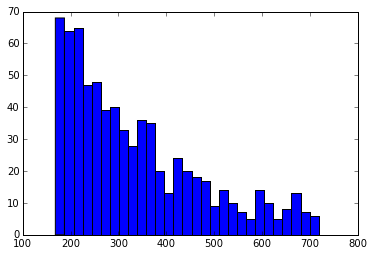

In [272]:
averageTimesFiltered = [averageTime for averageTime in averageTimes if averageTime >= 24*7 and averageTime <= 24*30]
print int(float(len(averageTimesFiltered))/len(averageTimes)*100),"%"
plt.hist(averageTimesFiltered, bins = 30-0.5)

In [283]:
with open('data/categoryPairs.json', 'w') as outfile:
    json.dump(TMUsersCategoriesList, outfile)

In [195]:
from itertools import tee, izip
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return izip(a, b)

In [189]:
print datetime.utcfromtimestamp(1435157570)
print datetime.utcfromtimestamp(1435155132)

2015-06-24 14:52:50
2015-06-24 14:12:12


In [284]:
TMUsersCategoriesList[0]

[(('Ramen / Noodle House', 'Ramen / Noodle House'), 1436),
 (('Ramen / Noodle House', 'Middle Eastern Restaurant'), 1420),
 (('Middle Eastern Restaurant', 'Gym / Fitness Center'), 3328),
 (('Gym / Fitness Center', 'Middle Eastern Restaurant'), 992),
 (('Middle Eastern Restaurant', 'Ramen / Noodle House'), 1433),
 (('Ramen / Noodle House', 'Ramen / Noodle House'), 4347),
 (('Ramen / Noodle House', 'Pub'), 454),
 (('Pub', 'French Restaurant'), 0),
 (('French Restaurant', 'Middle Eastern Restaurant'), 3870),
 (('Middle Eastern Restaurant', 'Ramen / Noodle House'), 1422),
 (('Ramen / Noodle House', 'Middle Eastern Restaurant'), 1465),
 (('Middle Eastern Restaurant', 'Gym / Fitness Center'), 518),
 (('Gym / Fitness Center', 'Conference'), 782),
 (('Conference', 'Middle Eastern Restaurant'), 1595),
 (('Middle Eastern Restaurant', 'Cocktail Bar'), 1468),
 (('Cocktail Bar', 'Middle Eastern Restaurant'), 2826),
 (('Middle Eastern Restaurant', 'Ramen / Noodle House'), 1415),
 (('Ramen / Noodle H

In [193]:
groupedUsersList

KeyError: 'Column not found: 0'